In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.preprocessing import text
import nltk
import re
nltk.download('stopwords')
from nltk.corpus import stopwords
import math

Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf


In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
from keras.preprocessing.sequence import pad_sequences

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
stopwords=set(stopwords.words('english'))

In [ ]:
df =pd.read_csv("/content/train.csv")

In [ ]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
y= np.array(df["target"])

In [ ]:

def remove_emoji(text):
  emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
  return emoji_pattern.sub(r'', text)

def clean(text):
  if str(text)=='nan':
    text = ''
  if str(text)!='nan':
    text = text.lower()
    text = re.sub(r'http\S+', ' ',text)
    text = ' '.join( [w for w in text.split() if len(w)>1] )
    text =" ".join([x for x in text.split() if x not in stopwords])
    text=re.sub("[^a-zA-Z]+"," ",text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)
    text=re.sub(' +', ' ', text)

  return text

In [ ]:
df['text']=df['text'].apply(lambda x: remove_emoji(x))
df['text']=df['text'].apply(lambda x: clean(x))

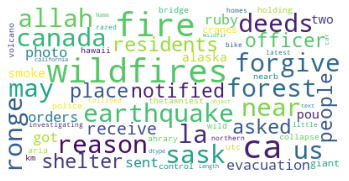

In [ ]:
from wordcloud import WordCloud
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(df['text']))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

In [ ]:
df["keyword"] = df["keyword"].apply(lambda x : clean(x))

In [ ]:
df.head()

,id,keyword,location,text,target
0,1,,NaN,deeds reason earthquake may allah forgive us,1
1,4,,NaN,forest fire near la ronge sask canada,1
2,5,,NaN,residents asked shelter place notified officer...,1
3,6,,NaN,people receive wildfires evacuation orders ca...,1
4,7,,NaN,got sent photo ruby alaska smoke wildfires pou...,1


In [ ]:
embeddings_dictionary = dict()
glove_file = open('/content/drive/My Drive/glove.6B.100d.txt', encoding="utf8")

In [ ]:
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
import operator
def build_vocab(X):
    
    tweets = X.apply(lambda s: s.split()).values      
    vocab = {}
    
    for tweet in tweets:
        for word in tweet:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1                
    return vocab


def check_embeddings_coverage(X, embeddings):
    
    vocab = build_vocab(X)    
    
    covered = {}
    oov = {}    
    n_covered = 0
    n_oov = 0
    
    for word in vocab:
        try:
            covered[word] = embeddings[word]
            n_covered += vocab[word]
        except:
            oov[word] = vocab[word]
            n_oov += vocab[word]
            
    vocab_coverage = len(covered) / len(vocab)
    text_coverage = (n_covered / (n_covered + n_oov))
    
    sorted_oov = sorted(oov.items(), key=operator.itemgetter(1))[::-1]
    return sorted_oov, vocab_coverage, text_coverage

train_glove_oov, train_glove_vocab_coverage, train_glove_text_coverage = check_embeddings_coverage(df['text'], embeddings_dictionary)

In [ ]:
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_glove_vocab_coverage, train_glove_text_coverage))

GloVe Embeddings cover 76.39% of vocabulary and 93.36% of text in Training Set


In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer 

# Init the Wordnet Lemmatizer
lemmatizer = WordNetLemmatizer()

In [ ]:
def lemma(text):
  word_list = nltk.word_tokenize(text)
  emmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
  return emmatized_output

In [ ]:
df["text"] = df["text"].apply(lambda x: lemma(x))

In [ ]:
from functools import reduce
import operator
def not_present(text):
  word_list = text.split()
  emmatized_output = ' '.join([w for w in word_list if w not in embeddings_dictionary.keys()])
  return emmatized_output

In [ ]:
from collections import Counter
def get_rareoov(xdict, val):
    return [k for (k,v) in Counter(xdict).items() if v<=val]

In [ ]:
df["oov"] = df["text"].apply(lambda x: not_present(x))
oov_vocab = []
for x in range(df["oov"].shape[0]):
  text = df["oov"][x]
  a_1 = text.split()
  for f in a_1:
    oov_vocab.append(f)  

In [ ]:
oov_rare = get_rareoov(oov_vocab, 1)

In [ ]:
def product(nums):
    "Return the product of a sequence of numbers."
    return reduce(operator.mul, nums, 1)

In [ ]:
class Pdist(dict):
  def __init__(self, data, N=None, missingfn=None):
    for key,count in data:
      self[key] = self.get(key, 0) + int(count)
    self.N = float(N or sum(self.itervalues( )))
    self.missingfn = missingfn or (lambda k, N: 1./N)
  def __call__(self, key):
    if key in self: return self[key]/self.N
    else: return self.missingfn(key, self.N)


def datafile(name, sep='\t'):
  file = open("/content/count_1w.txt", "r")
  for line in file:
    yield line.split(sep)

def avoid_long_words(word, N):
  return 10./(N * 10**len(word))

In [ ]:
N = 1024908267229 ## Number of tokens in corpus
Pw = Pdist(datafile('/content/count_1w.txt'), N, avoid_long_words)

In [ ]:
comman_vocab = dict()
file1 = open("/content/count_1w.txt", "r")
for line in file1:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1], dtype='float32')
    comman_vocab [word] = vector_dimensions

In [ ]:

def Pwords(words):
 return product(Pw(w) for w in words)

def splits(text, L=20):
 return [(text[:i+1], text[i+1:]) for i in range(min(len(text), L))]

def segment(text):
 if not text: return []
 candidates = ([first]+segment(rem) for first,rem in splits(text))
 return max(candidates, key=Pwords)

In [ ]:
df["oov"] = df["text"].apply(lambda x: not_present(x))

In [ ]:
def rare_removal(text):
  a= text.split()
  brown_tokens = [token for token in a if token not in oov_rare]
  brown_doc = ' '.join(brown_tokens)
  return brown_doc

In [ ]:
df["filter_text"] = df["text"].apply(lambda x: rare_removal(x))

In [ ]:
df["oov_new"] = df["filter_text"].apply(lambda x: not_present(x))

In [ ]:
oov_vocab = []
for x in range(df["oov_new"].shape[0]):
  text = df["oov_new"][x]
  a_1 = text.split()
  for f in a_1:
    oov_vocab.append(f)  

In [ ]:
corp_vocab = list(set(oov_vocab))

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(ngram_range=(1,1), vocabulary=corp_vocab)
X = cv.fit_transform(df["filter_text"])
Xc = (X.T * X)
Xc.setdiag(0)
coocc_ar = Xc.toarray()

In [ ]:
pip install mittens

In [ ]:
from mittens import  Mittens

In [ ]:
mittens_model = Mittens(n=100, max_iter=1000)
new_embeddings = mittens_model.fit(
    coocc_ar,
    vocab=corp_vocab,
    initial_embedding_dict= embeddings_dictionary)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Iteration 280: loss: 0.00011549534247023985

In [ ]:
import pickle
newglove = dict(zip(corp_vocab, new_embeddings))
f = open("repo_glove.pkl","wb")
pickle.dump(newglove, f)
f.close()

In [ ]:
for key,value in newglove.items():
  embeddings_dictionary[key] = value


In [ ]:
len(embeddings_dictionary.keys())

400402

In [ ]:
import pickle

In [ ]:
coocc_ar = Xc.toarray()

In [ ]:
corp_vocab = list(set(oov_vocab))

In [ ]:
from keras.preprocessing import text
tokenizer = text.Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True)
tokenizer.fit_on_texts(df["filter_text"])
detial_seq = tokenizer.texts_to_sequences(df["filter_text"])

In [ ]:
max_length=0
for x in detial_seq:
     a= len(x)
     if a>max_length:
        max_length=a


In [ ]:
padded_detial_seq = pad_sequences(detial_seq, max_length, padding='post')
#padded_keywords =  pad_sequences(keywords, max_length, padding='post')

In [ ]:
vocab_length = len(tokenizer.word_index)+1

In [ ]:
embedding_matrix = np.zeros((vocab_length, 100))
for word, index in tokenizer.word_index.items():

    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
import os


In [ ]:
print(tf.__version__)


2.2.0


In [ ]:
import tensorflow as tf

In [ ]:
tf.keras.backend.clear_session()


ValueError: ignored

In [ ]:
import os

In [ ]:
tpu_model.fit(padded_detial_seq, y,epochs=200,validation_split=0.1)

In [ ]:

def create_model():


  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Embedding(input_dim=vocab_length,
              input_length = max_length,
              output_dim=100,
              weights=[embedding_matrix],
              trainable=False,
              mask_zero=True))
  model.add(tf.keras.layers.Masking(mask_value=0.0))
  model.add(tf.keras.layers.LSTM(32, return_sequences=False,dropout=0.1, recurrent_dropout=0.1))
  model.add(tf.keras.layers.Dense(32, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
  optimizer = tf.keras.optimizers.Adam(lr=0.001, decay=0.001);
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
vocab_length

11533

In [ ]:
training_model = create_model()

In [ ]:
training_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 23, 100)           1153300   
_________________________________________________________________
masking_4 (Masking)          (None, 23, 100)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_8 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 1,171,413
Trainable params: 18,113
Non-trainable params: 1,153,300
_______________________________________

In [ ]:
history = training_model.fit(padded_detial_seq, y,
                    epochs=20,
                    batch_size=128,
                    validation_split=0.2)

Train on 6090 samples, validate on 1523 samples
Epoch 1/20
6090/6090 [==============================] - 12s 2ms/sample - loss: 0.6246 - accuracy: 0.6580 - val_loss: 0.5175 - val_accuracy: 0.7833
Epoch 2/20
6090/6090 [==============================] - 12s 2ms/sample - loss: 0.5268 - accuracy: 0.7627 - val_loss: 0.4654 - val_accuracy: 0.7905
Epoch 3/20
6090/6090 [==============================] - 12s 2ms/sample - loss: 0.4966 - accuracy: 0.7805 - val_loss: 0.4495 - val_accuracy: 0.7971
Epoch 4/20
6090/6090 [==============================] - 12s 2ms/sample - loss: 0.4732 - accuracy: 0.7920 - val_loss: 0.4380 - val_accuracy: 0.7945
Epoch 5/20
6090/6090 [==============================] - 12s 2ms/sample - loss: 0.4609 - accuracy: 0.8018 - val_loss: 0.4343 - val_accuracy: 0.8076
Epoch 6/20
6090/6090 [==============================] - 11s 2ms/sample - loss: 0.4477 - accuracy: 0.8066 - val_loss: 0.4348 - val_accuracy: 0.8070
Epoch 7/20
6090/6090 [==============================] - 12s 2ms/sample

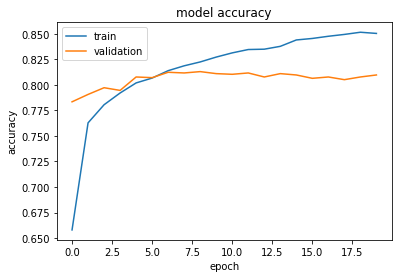

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])

Running on TPU  ['10.97.128.234:8470']


In [ ]:
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

strategy = tf.distribute.experimental.TPUStrategy(tpu)
print("REPLICAS: ", strategy.num_replicas_in_sync)

#
# Create model with TPU strategy
#
with strategy.scope():
  model = create_model()
  model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=[tf.keras.metrics.sparse_categorical_accuracy])

ValueError: ignored

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 23, 100)           1153300   
_________________________________________________________________
masking (Masking)            (None, 23, 100)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,199,765
Trainable params: 46,465
Non-trainable params: 1,153,300
_________________________________________

In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_host(resolver.master())
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.experimental.TPUStrategy(resolver)

ValueError: ignored

In [ ]:
import self

In [ ]:
pip install self

  Created wheel for self: filename=self-2019.4.13-cp36-none-any.whl size=1848 sha256=50cdcb86b167c248784688327a5806cf3e55ebd039d0ee6db1c5af31f16a1038
  Stored in directory: /root/.cache/pip/wheels/7c/79/c7/0c640a53559406ab162208d59d5a46946f85fb27f86a90d8ba
  Created wheel for public: filename=public-2019.4.13-cp36-none-any.whl size=2537 sha256=f796e754d36fde329a53536162f4ac91e981713bf7eebf02dcbea2b59f9b2423
  Stored in directory: /root/.cache/pip/wheels/23/7c/6e/f5b4e09d6596c8b8802b347e48f149031e2363368048f1347a
Successfully built self public


In [ ]:
config= tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)

AttributeError: ignored

In [ ]:

device_name = os.environ['COLAB_TPU_ADDR']
TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
print('Found TPU')


Found TPU


In [ ]:
with strategy.scope():
  model1 = create_model()
  model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  model1.fit(padded_detial_seq, epochs=200,validation_split=0.1,callbacks=[cp_callback])

InvalidArgumentError: ignored

In [ ]:
model.fit(padded_detial_seq,y , epochs=200,)

Train on 7613 samples
Epoch 1/200
7613/7613 [==============================] - ETA: 0s - loss: 0.5065 - accuracy: 0.7663
Epoch 00001: saving model to /content/training_7
7613/7613 [==============================] - 49s 6ms/sample - loss: 0.5065 - accuracy: 0.7663
Epoch 2/200
7613/7613 [==============================] - ETA: 0s - loss: 0.4457 - accuracy: 0.8066
Epoch 00002: saving model to /content/training_7
7613/7613 [==============================] - 50s 7ms/sample - loss: 0.4457 - accuracy: 0.8066
Epoch 3/200
7613/7613 [==============================] - ETA: 0s - loss: 0.4223 - accuracy: 0.8126
Epoch 00003: saving model to /content/training_7
7613/7613 [==============================] - 50s 7ms/sample - loss: 0.4223 - accuracy: 0.8126
Epoch 4/200
7613/7613 [==============================] - ETA: 0s - loss: 0.4070 - accuracy: 0.8246
Epoch 00004: saving model to /content/training_7
7613/7613 [==============================] - 50s 7ms/sample - loss: 0.4070 - accuracy: 0.8246
Epoch 5/20

KeyboardInterrupt: ignored

In [ ]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
test = pd.read_csv("test.csv")

In [ ]:
test['text']=test['text'].apply(lambda x : remove_URL(x))
test['text']=test['text'].apply(lambda x : remove_html(x))
test['text']=test['text'].apply(lambda x: remove_emoji(x))

In [ ]:
test["text"] =test["text"].apply(lambda x: lemma(x))

In [ ]:
test["text"]= test["text"].apply(lambda x: clean(x))

In [ ]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened terrible car crash
1,2,NaN,NaN,Heard earthquake different city stay safe ever...
2,3,NaN,NaN,forest fire spot pond goose fleeing across str...
3,9,NaN,NaN,Apocalypse lighting Spokane wildfire
4,11,NaN,NaN,Typhoon Soudelor kill China Taiwan


In [ ]:
test_detial_seq = tokenizer.texts_to_sequences(test["text"])

In [ ]:
test["text"][2]

'forest fire spot pond goose fleeing across street save'

In [ ]:
padded_test_detial_seq = pad_sequences(test_detial_seq, max_length, padding='post')


In [ ]:
test.head()

,id,target
0,0,1.0
1,2,1.0
2,3,1.0
3,9,1.0
4,11,1.0


In [ ]:
y_hat = model.predict(padded_test_detial_seq)

In [ ]:
y_pred = pd.DataFrame(y_hat)

In [ ]:
y_hat1=y_pred.round(0)

In [ ]:
test["target"] = y_hat1

In [ ]:
test.drop(columns=["keyword","location","text"],inplace=True)

In [ ]:
test.to_csv("answer.csv")

In [ ]:
y_hat1

,0
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
3258,1.0
3259,1.0
3260,1.0
3261,1.0


In [ ]:
y_hat1[0].value_counts()

0.0    2007
1.0    1256
Name: 0, dtype: int64

In [ ]:
()